In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 4.6MB/s 
     |████████████████████████████████| 194kB 18.5MB/s 
     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 1.2MB 18.8MB/s 
     |████████████████████████████████| 12.8MB 241kB/s 
     |████████████████████████████████| 776.8MB 25kB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from IPython.display import display,HTML

# Data Munging with fastai's Mid-Level API

## Going Deeper into fastai's Layered API

In [3]:
from fastai.text.all import *
URLs.IMDB

'https://s3.amazonaws.com/fast-ai-nlp/imdb.tgz'

In [4]:
dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')

In [5]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock), 
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

### Transforms

In [6]:
files = get_text_files(path, folders = ['train', 'test'])
txts = L(o.open().read() for o in files[:2000])

In [7]:
path

Path('/root/.fastai/data/imdb')

In [8]:
w_tkn = WordTokenizer() # using the default word tokenizer (spacy still?)

In [9]:
tok = Tokenizer(w_tkn)
tok.setup(txts)
toks = txts.map(tok)
toks[0]

(#321) ['xxbos','xxmaj','the','late','xxmaj','director','xxmaj','john','xxmaj','frankenheimer'...]

In [10]:
tok = Tokenizer.from_folder(path)
tok.setup(txts)
toks = txts.map(tok)
toks[0]

(#321) ['xxbos','xxmaj','the','late','xxmaj','director','xxmaj','john','xxmaj','frankenheimer'...]

In [11]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10]

TensorText([   2,    8,    9,  445,    8,  184,    8,  278,    8, 8518])

In [12]:
nums_dec = num.decode(nums[0][:10]); 
nums_dec

(#10) ['xxbos','xxmaj','the','late','xxmaj','director','xxmaj','john','xxmaj','frankenheimer']

In [13]:
tok.decode(nums_dec)

'xxbos xxmaj the late xxmaj director xxmaj john xxmaj frankenheimer'

In [14]:
tok((txts[0], txts[1]))

((#321) ['xxbos','xxmaj','the','late','xxmaj','director','xxmaj','john','xxmaj','frankenheimer'...],
 (#98) ['xxbos','xxmaj','great','movie','!','oh','yeah','!','xxmaj','full'...])

There is always a decode method for such transforms.

### Writing Your Own Transform

In [24]:
def f(x:int): return x+1

In [25]:
tfm = Transform(f)

In [26]:
tfm(2)

3

In [27]:
tfm(4)

5

Doesnt get applied if not int. due to x:int

In [23]:
tfm(4.3)

4.3

In [22]:
tfm?

In [69]:
def do_twice(func):
    def wrapper_do_twice(*args, **kwargs):
        func(*args, **kwargs)
        return func(*args, **kwargs)
    return wrapper_do_twice #return the modified function
    # can return the unmodified function func as well.

@do_twice
def return_greeting(name):
    print("Creating greeting")
    return f"Hi {name}"

@do_twice
def say_whee():
    print("Whee!")

In [70]:
return_greeting('Geo')

Creating greeting
Creating greeting


'Hi Geo'

In [71]:
say_whee()

Whee!
Whee!


In [72]:
print.__name__

'print'

In [73]:
say_whee.__name__

'wrapper_do_twice'

The name is not correct. say_whee says its an inner function of do_twice.

In [74]:
import functools 

def do_twice(func):
    @functools.wraps(func)
    def wrapper_do_twice(*args, **kwargs):
        func(*args, **kwargs)
        return func(*args, **kwargs)
    return wrapper_do_twice #return the modified function

@do_twice
def return_greeting(name):
    print("Creating greeting")
    return f"Hi {name}"

@do_twice
def say_whee():
    """
    says whee when requested
    """
    print("Whee!")

In [75]:
say_whee.__name__

'say_whee'

In [77]:
help(say_whee)

Help on function say_whee in module __main__:

say_whee()
    says whee when requested



In [80]:
@Transform # 
def f(x:int): return x+1 # function that gets passed into Transform class.
f(2),f(2.0)

(3, 2.0)

In [81]:
class NormalizeMean(Transform):
    def setups(self, items): self.mean = sum(items)/len(items)
    def encodes(self, x): return x-self.mean
    def decodes(self, x): return x+self.mean

In [84]:
tfm = NormalizeMean()
tfm.setup([1,2,3,4,5])
start = 2
y = tfm(start)
z = tfm.decode(y)
tfm.mean,y,z

(3.0, -1.0, 2.0)

### Pipeline

In [88]:
tok?

In [87]:
num?

In [89]:
tfms = Pipeline([tok, num])
t = tfms(txts[0]); t[:20]

TensorText([   2,    8,    9,  445,    8,  184,    8,  278,    8, 8518,  487,   34,  100, 1091,   30,   10,    8,    9,    8,  162])

In [90]:
tfms.decode(t)[:100]

'xxbos xxmaj the late xxmaj director xxmaj john xxmaj frankenheimer directed his first feature film ,'

## TfmdLists and Datasets: Transformed Collections

### TfmdLists

In [91]:
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize])

In [92]:
t = tls[0]; t[:20]

TensorText([    2,     8,     9,   564,     8,   172,     8,   319,     8, 20124,   536,    41,   107,   820,    32,    11,     8,     9,     8,   211])

In [93]:
tls.decode(t)[:100]

'xxbos xxmaj the late xxmaj director xxmaj john xxmaj frankenheimer directed his first feature film ,'

In [94]:
tls.show(t)

xxbos xxmaj the late xxmaj director xxmaj john xxmaj frankenheimer directed his first feature film , xxmaj the xxmaj young xxmaj stranger , after starting out directing live television dramas in xxmaj new xxmaj york xxmaj city . xxmaj this film came on the heels of the success of xxmaj rebel xxmaj without a xxmaj cause in 1955 . xxmaj james macarthur made his feature film debut as a troubled teen with a movie producer father , played by xxmaj james xxmaj daly , who does n't establish enough of a relationship with his son . xxmaj kim xxmaj hunter plays the mother , who tries to bridge the gap between her husband and her son . xxmaj the film uses the popular juvenile delinquent angle of the time to tell its story . macarthur gets in trouble at a movie theater with an overzealous theater manager played by xxmaj whit xxmaj bissell . macarthur , in turn , has to deal with a police sergeant , xxmaj james xxmaj gregory , bent on teaching him a lesson . xxmaj the material could easily have tur

In [95]:
files

(#50000) [Path('/root/.fastai/data/imdb/test/pos/4814_7.txt'),Path('/root/.fastai/data/imdb/test/pos/8791_8.txt'),Path('/root/.fastai/data/imdb/test/pos/8633_7.txt'),Path('/root/.fastai/data/imdb/test/pos/10543_7.txt'),Path('/root/.fastai/data/imdb/test/pos/9188_8.txt'),Path('/root/.fastai/data/imdb/test/pos/11888_10.txt'),Path('/root/.fastai/data/imdb/test/pos/10728_8.txt'),Path('/root/.fastai/data/imdb/test/pos/10360_9.txt'),Path('/root/.fastai/data/imdb/test/pos/10119_10.txt'),Path('/root/.fastai/data/imdb/test/pos/11136_10.txt')...]

In [96]:
cut = int(len(files)*0.8)
splits = [list(range(cut)), list(range(cut,len(files)))]
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize], 
                splits=splits)

In [97]:
tls.valid[0][:20]

TensorText([    2,     8,   636,    11,     8,    19,   169,    45,    29, 18195,   751,  1293,    12,   106,    99,  2138,   104,     8,   694,     8])

In [98]:
lbls = files.map(parent_label)
lbls

(#50000) ['pos','pos','pos','pos','pos','pos','pos','pos','pos','pos'...]

In [100]:
cat = Categorize()
cat.setup(lbls)
cat.vocab, cat(lbls[0]), cat(lbls[1])

(['neg', 'pos'], TensorCategory(1), TensorCategory(1))

In [101]:
tls_y = TfmdLists(files, [parent_label, Categorize()])
tls_y[0]

TensorCategory(1)

### Datasets

In [102]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms])
x,y = dsets[0]
x[:20],y

(TensorText([    2,     8,     9,   564,     8,   172,     8,   319,     8, 20124,   536,    41,   107,   820,    32,    11,     8,     9,     8,   211]),
 TensorCategory(1))

In [103]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms], splits=splits)
x,y = dsets.valid[0]
x[:20],y

(TensorText([    2,     8,   636,    11,     8,    19,   169,    45,    29, 18195,   751,  1293,    12,   106,    99,  2138,   104,     8,   694,     8]),
 TensorCategory(0))

In [104]:
t = dsets.valid[0]
dsets.decode(t)

("xxbos xxmaj seriously , xxmaj i 'm all for gooey romantic comedies and will get sucked into xxmaj miss xxmaj congeniality as easily as xxmaj goodfellas … but this movie ? xxmaj it does n't make any sense xxrep 4 ! xxmaj and xxmaj i 'm not even talking about the willing suspension of disbelief kind of not making sense . xxmaj why does her family live in xxmaj england ? xxmaj or , at the very least , why does n't she have a xxmaj british accent ? xxmaj she 's sure cozy with her dad and he 's surprisingly forgiving of her not being around for the last two years . ( on that subject , no one ever makes much of a deal about her being away for so long ) . xxmaj and what was with the goofy outfits at the bachelorette party ? xxmaj i 'm not even going to get into the fact that the escort she paid for falls in love with her -- that could 've been overcome by better movie - making . xxmaj i 'm just saying that the characters , the setting , and the plot are n't fleshed out enough to make an eve

In [105]:
dls = dsets.dataloaders(bs=64, before_batch=pad_input)

In [106]:
tfms = [[Tokenizer.from_folder(path), Numericalize], [parent_label, Categorize]] # passing xy transforms together
files = get_text_files(path, folders = ['train', 'test'])
splits = GrandparentSplitter(valid_name='test')(files)
dsets = Datasets(files, tfms, splits=splits)
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=pad_input)

In [107]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

## Applying the Mid-Level Data API: SiamesePair

Use the tensorflow flowers dataset instead.

In [109]:
url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
path = download_data(url)
path.as_posix()

'/root/.fastai/archive/flower_photos.tgz'

In [116]:
data = untar_data(path.as_posix()) # or pass str(path)
(data).ls()

(#6) [Path('/root/.fastai/data/flower_photos/LICENSE.txt'),Path('/root/.fastai/data/flower_photos/dandelion'),Path('/root/.fastai/data/flower_photos/sunflowers'),Path('/root/.fastai/data/flower_photos/daisy'),Path('/root/.fastai/data/flower_photos/tulips'),Path('/root/.fastai/data/flower_photos/roses')]

In [117]:
from fastai.vision.all import *
path = data
files = get_image_files(path)

In [118]:
files

(#3670) [Path('/root/.fastai/data/flower_photos/dandelion/1128626197_3f52424215_n.jpg'),Path('/root/.fastai/data/flower_photos/dandelion/2330343016_23acc484ee.jpg'),Path('/root/.fastai/data/flower_photos/dandelion/7295618968_c08a326cc1_m.jpg'),Path('/root/.fastai/data/flower_photos/dandelion/451965300_619b781dc9_m.jpg'),Path('/root/.fastai/data/flower_photos/dandelion/6888894675_524a6accab_n.jpg'),Path('/root/.fastai/data/flower_photos/dandelion/506659320_6fac46551e.jpg'),Path('/root/.fastai/data/flower_photos/dandelion/151861297_55b10a03a6_n.jpg'),Path('/root/.fastai/data/flower_photos/dandelion/4633514720_22e82c5f7c_m.jpg'),Path('/root/.fastai/data/flower_photos/dandelion/2503034372_db7867de51_m.jpg'),Path('/root/.fastai/data/flower_photos/dandelion/16953818045_fea21c8bf8.jpg')...]

In [119]:
isinstance?

In [121]:
Tensor.permute? # Returns a view of the original tensor with its dimensions permuted, The desired ordering of dimensions (2,0,1)

In [126]:
class SiameseImage(fastuple): # get init from fastuple
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self # image, 
        if not isinstance(img1, Tensor): # check if image is of tensor class
            if img2.size != img1.size:  # check if images are of same size, cos have to create a single frame
              img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2) # make images to tensors
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2 
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10) # make an array of zeros of this shape 
        return show_image(torch.cat([t1,line,t2], dim=2), 
                          title=same_breed, ctx=ctx)

The case where two images are same

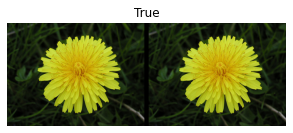

In [127]:
img = PILImage.create(files[0])
s = SiameseImage(img, img, True)
s.show();

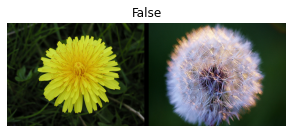

In [128]:
img1 = PILImage.create(files[1])
img = PILImage.create(files[0])
s1 = SiameseImage(img, img1, False)
s1.show();

In [133]:
Resize??

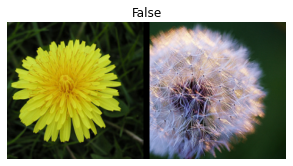

In [136]:
s2 = Resize(224)(s1)
s2.show();

In [144]:
files.map(parent_label)

(#3670) ['dandelion','dandelion','dandelion','dandelion','dandelion','dandelion','dandelion','dandelion','dandelion','dandelion'...]

In [151]:
def label_func(fname):
    return parent_label(fname)
    #return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

In [152]:
label_func(files[0])

'dandelion'

In [154]:
labels = files.map(parent_label).unique()
labels

(#5) ['dandelion','sunflowers','daisy','tulips','roses']

Make a dictionary with correspoinding flowers

In [155]:
{l: L(f for f in files if label_func(f) == l) for l in labels} # L makes a list

{'daisy': (#633) [Path('/root/.fastai/data/flower_photos/daisy/5135131051_102d4878ca_n.jpg'),Path('/root/.fastai/data/flower_photos/daisy/4561871220_47f420ca59_m.jpg'),Path('/root/.fastai/data/flower_photos/daisy/2619413565_61a6cd3ac9_m.jpg'),Path('/root/.fastai/data/flower_photos/daisy/8446495985_f72d851482.jpg'),Path('/root/.fastai/data/flower_photos/daisy/11870378973_2ec1919f12.jpg'),Path('/root/.fastai/data/flower_photos/daisy/8694909523_3ca25d449d_n.jpg'),Path('/root/.fastai/data/flower_photos/daisy/5434913005_409c1e8b56_n.jpg'),Path('/root/.fastai/data/flower_photos/daisy/7630511450_02d3292e90.jpg'),Path('/root/.fastai/data/flower_photos/daisy/4694730335_2553e77aa5_z.jpg'),Path('/root/.fastai/data/flower_photos/daisy/9346508462_f0af3163f4.jpg')...],
 'dandelion': (#898) [Path('/root/.fastai/data/flower_photos/dandelion/1128626197_3f52424215_n.jpg'),Path('/root/.fastai/data/flower_photos/dandelion/2330343016_23acc484ee.jpg'),Path('/root/.fastai/data/flower_photos/dandelion/7295618

In [159]:
# splits[1] 
cut = int(len(files)*0.8)
splits = [list(range(cut)), list(range(cut,len(files)))] # with train and valid indices

In [161]:
files[splits[1][0]]

Path('/root/.fastai/data/flower_photos/tulips/6934951920_d43ff8b78d.jpg')

In [182]:
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(parent_label).unique() # get all the possible labels
        self.lbl2files = {l: L(f for f in files if label_func(f) == l) 
                          for l in self.labels} # make a list of the form {'class': [files]}
        self.label_func = label_func
        self.valid_split = files[splits[1]]
        self.valid = {f: self._draw(f) for f in self.valid_split} # to make sure validation set is alwas the same
        # make the validation dict randomly from the valid split
        # with f is the file name key value would be the new file
        
    def encodes(self, f):
        f2, t = self.valid.get(f, self._draw(f)) # get is a dict function to get for the key f, find a value from its values (valid)
        # get a pair for f and the bool if it is true/false
        self.img1_class, self.img2_class = self.label_func(f), self.label_func(f2)
        self.img1, self.img2 = PILImage.create(f),PILImage.create(f2) # cleate Pillow image, will be made tensor by the SiameseImage class
        return SiameseImage(self.img1, self.img2, t) # class that makes a siamese image. It takes a tuple
    
    def _draw(self, f): # function to pick an image
        same = random.random() < 0.5 # random probaility less than 0.5 then it will be same, a boolean
        cls = self.label_func(f) # class of file to pick one from its own class, available in lbl2files dict
        if not same: # if opposite of same
            cls = random.choice(L(l for l in self.labels if l != cls)) # else pick a class thats not from the same class.
        return random.choice(self.lbl2files[cls]),same 
        # if the same condition is met, then normally pick a file from the same class.
        # also return the bool if it is true or false

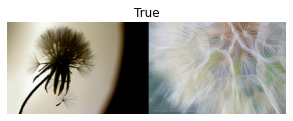

In [186]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tfm(files[4]).show();

In [184]:
splits 

((#2936) [1418,3554,2515,712,2504,808,1371,1149,1555,41...],
 (#734) [3227,1428,1362,1125,1885,2259,2490,2629,1052,918...])

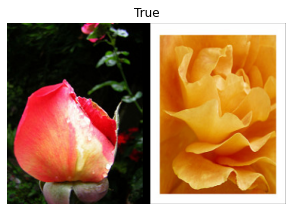

In [187]:
tls = TfmdLists(files, tfm, splits=splits)
show_at(tls.valid, 0);

In [189]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [193]:
dls.one_batch()

(TensorImage([[[[ 1.0331,  1.0502,  1.0159,  ...,  0.3309,  0.2967,  0.2967],
           [ 0.9988,  1.0159,  1.0159,  ...,  0.3138,  0.2796,  0.2796],
           [ 0.9817,  0.9988,  1.0159,  ...,  0.2967,  0.2796,  0.2624],
           ...,
           [-0.5424, -0.5938, -0.6623,  ..., -1.1932, -0.9877, -0.9534],
           [-0.5938, -0.6109, -0.6452,  ..., -1.3130, -1.0048, -0.9363],
           [-0.6109, -0.6109, -0.6452,  ..., -1.4672, -1.1247, -0.9192]],
 
          [[ 0.8354,  0.8529,  0.8529,  ..., -0.1450, -0.1625, -0.1625],
           [ 0.8179,  0.8529,  0.8529,  ..., -0.1625, -0.1800, -0.1800],
           [ 0.8179,  0.8354,  0.8529,  ..., -0.1975, -0.1800, -0.1975],
           ...,
           [-0.5826, -0.6352, -0.6877,  ..., -0.8803, -0.8627, -1.0728],
           [-0.6176, -0.6352, -0.6702,  ..., -1.0378, -0.8277, -0.9678],
           [-0.6001, -0.6352, -0.6702,  ..., -1.1779, -0.8978, -0.8627]],
 
          [[ 0.6356,  0.6531,  0.6531,  ..., -0.5844, -0.6018, -0.5844],
        

## Conclusion

## Questionnaire

1. Why do we say that fastai has a "layered" API? What does it mean?
1. Why does a `Transform` have a `decode` method? What does it do?
1. Why does a `Transform` have a `setup` method? What does it do?
1. How does a `Transform` work when called on a tuple?
1. Which methods do you need to implement when writing your own `Transform`?
1. Write a `Normalize` transform that fully normalizes items (subtract the mean and divide by the standard deviation of the dataset), and that can decode that behavior. Try not to peek!
1. Write a `Transform` that does the numericalization of tokenized texts (it should set its vocab automatically from the dataset seen and have a `decode` method). Look at the source code of fastai if you need help.
1. What is a `Pipeline`?
1. What is a `TfmdLists`? 
1. What is a `Datasets`? How is it different from a `TfmdLists`?
1. Why are `TfmdLists` and `Datasets` named with an "s"?
1. How can you build a `DataLoaders` from a `TfmdLists` or a `Datasets`?
1. How do you pass `item_tfms` and `batch_tfms` when building a `DataLoaders` from a `TfmdLists` or a `Datasets`?
1. What do you need to do when you want to have your custom items work with methods like `show_batch` or `show_results`?
1. Why can we easily apply fastai data augmentation transforms to the `SiamesePair` we built?

### Further Research

1. Use the mid-level API to prepare the data in `DataLoaders` on your own datasets. Try this with the Pet dataset and the Adult dataset from Chapter 1.
1. Look at the Siamese tutorial in the fastai documentation to learn how to customize the behavior of `show_batch` and `show_results` for new type of items. Implement it in your own project.

## Understanding fastai's Applications: Wrap Up

Congratulations—you've completed all of the chapters in this book that cover the key practical parts of training models and using deep learning! You know how to use all of fastai's built-in applications, and how to customize them using the data block API and loss functions. You even know how to create a neural network from scratch, and train it! (And hopefully you now know some of the questions to ask to make sure your creations help improve society too.)

The knowledge you already have is enough to create full working prototypes of many types of neural network applications. More importantly, it will help you understand the capabilities and limitations of deep learning models, and how to design a system that's well adapted to them.

In the rest of this book we will be pulling apart those applications, piece by piece, to understand the foundations they are built on. This is important knowledge for a deep learning practitioner, because it is what allows you to inspect and debug models that you build and create new applications that are customized for your particular projects.